In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import random
device = torch.device("cuda:5" if torch.cuda.is_available() else "cpu")

In [2]:
tasks = {
    "classify_boundary": {"input_dim": 2, "output_dim": 1},
    "add_numbers": {"input_dim": 2, "output_dim": 1},
    "subtract_numbers": {"input_dim": 2, "output_dim": 1}
}

In [3]:
# Dataset
class TaskDataset(Dataset):
    def __init__(self, task, num_samples=1000, num_points_per_sample=100):
        self.task = task
        self.num_samples = num_samples
        self.num_points_per_sample = num_points_per_sample
        self.offset = torch.randint(0, 5, (1,)).item()
        self.data, self.labels = self.generate_data(task, num_samples, num_points_per_sample)
    
    def generate_data(self, task, num_samples, num_points_per_sample):
        data = []
        labels = []
        for _ in range(num_samples):
            if task == "classify_boundary":
                x = torch.randint(-10, 10, (num_points_per_sample, 2)).float()
                y = (x[:, 0] + x[:, 1] > self.offset).float().unsqueeze(1)
            elif task == "add_numbers":
                a = torch.randint(0, 100, (num_points_per_sample, 1)).float()
                b = torch.randint(0, 100, (num_points_per_sample, 1)).float()
                x = torch.cat([a, b], dim=1)
                y = a + b + self.offset
            elif task == "subtract_numbers":
                a = torch.randint(0, 100, (num_points_per_sample, 1)).float()
                b = torch.randint(0, 100, (num_points_per_sample, 1)).float()
                x = torch.cat([a, b], dim=1)
                y = a - b + self.offset
            elif task == "multiclass_boundary":
                x = torch.randint(-10, 10, (num_points_per_sample, 2)).float()
                y = torch.zeros(num_points_per_sample, 1)
                y[(x[:, 0] + x[:, 1] > self.offset), 0] = 1
                y[(x[:, 0] - x[:, 1] > self.offset), 0] += 1
            data.append(x)
            labels.append(y)
        return data, labels
    
    def __len__(self):
        return self.num_samples
    
    def __getitem__(self, idx):
        x = self.data[idx]
        y = self.labels[idx]
        # Flatten x and y
        x_flat = x.view(-1)
        y_flat = y.view(-1)
        xy = torch.cat((x_flat, y_flat), dim=0)
        return xy
    
    def get_offset(self):
        return self.offset

In [4]:
class Encoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__()
        # Data understanding layers
        self.feature_extractor = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
        )
        
        # Task understanding
        self.task_head = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, latent_dim)
        )

    def forward(self, x):
        # Extract features
        features = self.feature_extractor(x)
        # Infer task embedding
        z = self.task_head(features)
        return z

In [5]:
# Define the MetaModel that generates weight matrices
class MetaModel(nn.Module):
    def __init__(self, latent_dim, mlp_input_dim, mlp_hidden_dim, mlp_output_dim):
        super(MetaModel, self).__init__()
        total_weights = (mlp_input_dim * mlp_hidden_dim) + (mlp_hidden_dim * mlp_output_dim)
        hidden_size = 1024  # Increased hidden size for the MetaModel

        # Adding more layers and dropout to the MetaModel
        self.fc = nn.Sequential(
            nn.Linear(latent_dim + 1, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, total_weights)
        )

        self.mlp_input_dim = mlp_input_dim
        self.mlp_hidden_dim = mlp_hidden_dim
        self.mlp_output_dim = mlp_output_dim

    def forward(self, z):
        weights = self.fc(z)
        # Split weights into two matrices for a two-layer MLP
        w1_size = self.mlp_input_dim * self.mlp_hidden_dim
        w2_size = self.mlp_hidden_dim * self.mlp_output_dim
        W1 = weights[:, :w1_size].view(-1, self.mlp_hidden_dim, self.mlp_input_dim)
        W2 = weights[:, w1_size:].view(-1, self.mlp_output_dim, self.mlp_hidden_dim)
        return W1, W2

In [6]:
# Initialize Model
num_points_per_sample = 200
input_dim_per_point = 2
output_dim_per_point = 1
input_dim = num_points_per_sample * (input_dim_per_point + output_dim_per_point)
latent_dim = 20
encoder = Encoder(input_dim=input_dim, latent_dim=latent_dim).to(device)
encoder.load_state_dict(torch.load('encoder_weights.pth'))
encoder.eval()  # Set encoder to evaluation mode


# Parameters for the MLP
mlp_input_dim = 2
mlp_hidden_dim = 128  # Increased hidden dimension
mlp_output_dim = 1  # Output dimension is 1 for all tasks

# Initialize the MetaModel
meta_model = MetaModel(latent_dim, mlp_input_dim, mlp_hidden_dim, mlp_output_dim).to(device)
optimizer = optim.Adam(meta_model.parameters(), lr=1e-3)

# Training loop
epochs = 20
batch_size = 128

/tmp/ipykernel_1676543/3736637237.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load('encoder_weights.pth'))


In [7]:
def get_task_sequence(iteration, total_iterations=15):
    if iteration < 13:
        # First 7 iterations alternate between add and subtract
        return 'add_numbers' if iteration % 2 == 0 else 'subtract_numbers'
    elif iteration < 18:
        # Next 5 iterations are classification
        return 'classify_boundary'
    else:
        # Last 3 iterations alternate between add and subtract
        return 'add_numbers' if iteration % 2 == 0 else 'subtract_numbers'

In [8]:
task_losses = {
        'classify_boundary': {'instant': []},
        'add_numbers': {'instant': []},
        'subtract_numbers': {'instant': []}
    }


for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    meta_model.train()
    task = get_task_sequence(epoch)
    for _ in range(100):
        dataset = TaskDataset(task, num_samples=(batch_size * 10), num_points_per_sample=num_points_per_sample)
        valadation = TaskDataset(task, num_samples=(batch_size * 10), num_points_per_sample=num_points_per_sample)
        loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
        valloader = DataLoader(valadation, batch_size=batch_size, shuffle=True)
        
        for xy in loader:
            for valxy in valloader:
                break
                
            xy = xy.to(device)
            valxy = valxy.to(device)
            x_size = input_dim_per_point * num_points_per_sample
            
            # Shape: [batch_size, num_points, input_dim]
            x = valxy[:, :x_size].view(-1, num_points_per_sample, input_dim_per_point).to(device)
            # Shape: [batch_size, num_points, 1]
            y = valxy[:, x_size:].view(-1, num_points_per_sample, output_dim_per_point).to(device)
            
            with torch.no_grad():
                z = encoder(xy)
                if task == "add_numbers":
                    task_indicator = torch.ones(z.size(0), 1).to(z.device)
                elif task == "subtract_numbers":
                    task_indicator = torch.full((z.size(0), 1), 2).to(z.device)
                else:
                    task_indicator = torch.zeros(z.size(0), 1).to(z.device)
                z = torch.cat((z, task_indicator), dim=1)
            
            # Generate weights
            W1, W2 = meta_model(z)  # W1: [batch, hidden_dim, input_dim], W2: [batch, output_dim, hidden_dim]
            
            # Process each point in the sequence
            batch_size, num_points, _ = x.shape
            x_flat = x.reshape(batch_size * num_points, input_dim_per_point)
            
            # Apply W1 to all points
            h = F.relu(torch.mm(x_flat, W1[0].t()))  # [batch*num_points, hidden_dim]
            
            # Apply W2 to get outputs
            outputs = torch.mm(h, W2[0].t())  # [batch*num_points, output_dim]
            
            # Reshape outputs to match y
            outputs = outputs.view(batch_size, num_points, output_dim_per_point)
            
            # Compute loss
            if task == "classify_boundary":
                outputs = torch.sigmoid(outputs)
                loss = F.binary_cross_entropy(outputs, y.float())
            else:
                loss = F.mse_loss(outputs, y)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            task_losses[task]['instant'].append(loss.item())
    print(f"Task: {task}, Loss: {loss.item():.4f}")
            

Epoch 1/20
Task: add_numbers, Loss: 10323.5537
Epoch 2/20
Task: subtract_numbers, Loss: 864.1284
Epoch 3/20
Task: add_numbers, Loss: 92429.6797
Epoch 4/20
Task: subtract_numbers, Loss: 212.8161
Epoch 5/20
Task: add_numbers, Loss: 47.0689
Epoch 6/20
Task: subtract_numbers, Loss: 8.0247
Epoch 7/20
Task: add_numbers, Loss: 67.3189
Epoch 8/20
Task: subtract_numbers, Loss: 58.2028
Epoch 9/20
Task: add_numbers, Loss: 5.0257
Epoch 10/20
Task: subtract_numbers, Loss: 3.5109
Epoch 11/20
Task: add_numbers, Loss: 5.5948
Epoch 12/20
Task: subtract_numbers, Loss: 37.0811
Epoch 13/20
Task: add_numbers, Loss: 7.7444
Epoch 14/20
Task: classify_boundary, Loss: 0.0939
Epoch 15/20
Task: classify_boundary, Loss: 0.0800
Epoch 16/20
Task: classify_boundary, Loss: 0.1076
Epoch 17/20
Task: classify_boundary, Loss: 0.1064
Epoch 18/20
Task: classify_boundary, Loss: 0.0677
Epoch 19/20
Task: add_numbers, Loss: 3.5002
Epoch 20/20
Task: subtract_numbers, Loss: 5.1857


In [10]:
torch.save(task_losses, 'task_losses1.pt')

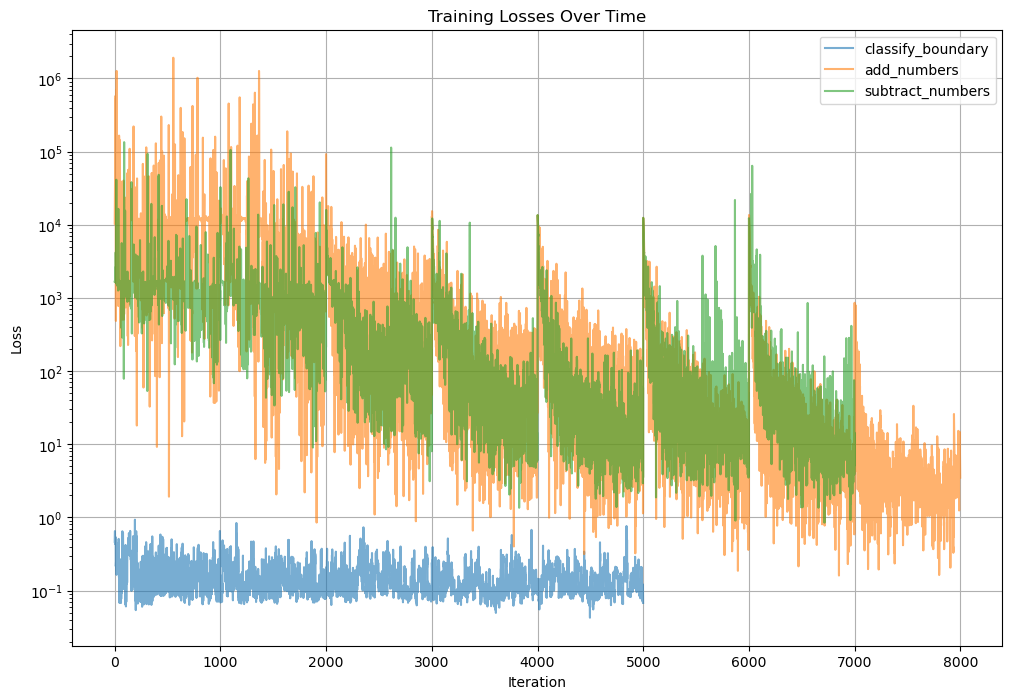

In [9]:
import matplotlib.pyplot as plt
import os
from datetime import datetime


# Plot losses
plt.figure(figsize=(12, 8))
for task, losses in task_losses.items():
    plt.plot(losses['instant'], label=f'{task}', alpha=0.6)
plt.title('Training Losses Over Time')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.grid(True)
plt.legend()
plt.show()



torch.save(meta_model.state_dict(), 'meta_model_weights.pth')